In [95]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures as pf
from sklearn.preprocessing import LabelEncoder as le
from sklearn.linear_model import LinearRegression as lr
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline, Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
sns.set_style('whitegrid')

import numpy as np

from collections import Counter
import tabulate as tb

np.random.seed(42)

def plot_labels(t='', x='', y=''):
    plt.title(t)
    plt.xlabel(x)
    plt.ylabel(y)


In [96]:
test_d = pd.read_csv('./data/gss_test.csv')
train_d = pd.read_csv('./data/gss_train.csv')

assert set(test_d.columns) == set(train_d.columns)

maps = {}

for col in test_d.columns:
    d1, d2 = list(test_d[col]), list(train_d[col])
    encoder = le().fit(d1+d2)
    test_d[col] = encoder.transform(d1)
    train_d[col] = encoder.transform(d2)
    maps[col] = encoder.classes_

#print(f"Shapes\nTrain: {train_d.shape}\nTest: {test_d.shape}")
test_d, train_d = test_d.dropna(axis=0), train_d.dropna(axis=0)
#print(Counter(train_d.dtypes), Counter(test_d.dtypes))
#print(f"Shapes after dropping NaNs\nTrain: {train_d.shape}\nTest: {test_d.shape}")
      
x_tr, y_tr = train_d.drop('egalit_scale', axis=1), train_d['egalit_scale']
x_te, y_te = test_d.drop('egalit_scale', axis=1), train_d['egalit_scale']

x_tr, y_tr, x_te, y_te = [i.to_numpy() for i in [x_tr, y_tr, x_te, y_te]]
y_tr, y_te = (i.reshape(-1, 1) for i in (y_tr, y_te))

In [97]:
train_d.head()

,age,attend,authoritarianism,black,born,childs,colath,colrac,colcom,colmil,...,social_connect,social_cons3,south,spend3,teensex,tolerance,tvhours,vetyears,wordsum,zodiac
0,3,4,4,0,1,0,1,1,0,1,...,5,2,0,0,1,10,3,3,5,1
1,24,4,4,0,1,2,0,1,1,0,...,5,1,0,2,2,13,3,3,6,1
2,52,1,1,1,1,3,0,1,1,0,...,5,1,0,0,1,10,3,3,6,10
3,17,8,2,0,1,2,0,1,0,1,...,10,1,0,1,1,11,3,3,6,9
4,6,8,6,0,0,3,1,1,0,0,...,4,2,0,0,0,7,2,3,4,9


In [98]:
inc_tr, inc_te = (np.array(i).reshape(-1, 1) for i in (train_d['income06'], test_d['income06']))

In [117]:
steps=[('poly', pf()), ('lr', lr())]
polyregression = Pipeline(steps)

parameters = {'poly__degree': range(1, 51)}
# sklearn is weird and MSE is actually negative
scorer = make_scorer(MSE, greater_is_better=False)
cv = GridSearchCV(polyregression, parameters, scoring=scorer, cv=10)

cv.fit(inc_tr, y_tr)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('poly',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('lr',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'poly__degree': range(1, 51)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False,
    

In [118]:
results = pd.DataFrame(cv.cv_results_)
bestimator = cv.best_estimator_
best_d = cv.best_params_['poly__degree']

Pipeline(memory=None,
         steps=[('poly',
                 PolynomialFeatures(degree=21, include_bias=True,
                                    interaction_only=False, order='C')),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)


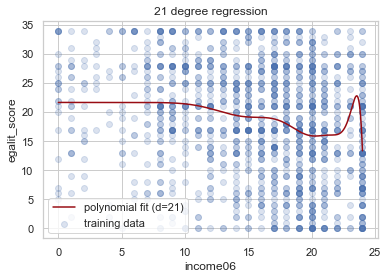

In [119]:
print(bestimator)

inc_plot = np.linspace(inc_tr.min(), inc_tr.max(), 10000).reshape(-1, 1)
y_plot = bestimator.predict(inc_plot)

plt.scatter(inc_tr, y_tr, label='training data', alpha=0.2)
plt.plot(inc_plot, y_plot, label=f'polynomial fit (d={best_d})', c=plt.cm.Reds(0.9))
plt.legend()
plot_labels(f'{best_d} degree regression', 'income06', 'egalit_score')

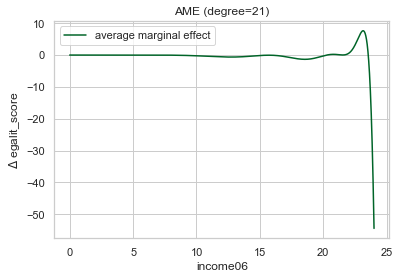

In [116]:
spacing = float(inc_plot[1]-inc_plot[0])
ame_plot = np.gradient(y_plot.reshape(-1), spacing)

plt.plot(inc_plot, ame_plot, label=f'average marginal effect', c=plt.cm.Greens(0.9))
plt.legend()
plot_labels(f'AME (degree={best_d})', 'income06', r'$\Delta$ egalit_score')

## insert bullshit here

In [126]:
from sklearn.preprocessing import KBinsDiscretizer as kb
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html

step_predictor = Pipeline([('cut', kb()), ('lr', lr())])
parameters = {'cut__n_bins': range(1, 20)}

cv = GridSearchCV(step_predictor, parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=10)

cv.fit(inc_tr, y_tr)
bestimator = cv.best_estimator_
best_cuts = cv.best_params_['cut__n_bins']

Pipeline(memory=None,
         steps=[('cut',
                 KBinsDiscretizer(encode='onehot', n_bins=3,
                                  strategy='quantile')),
                ('lr',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)


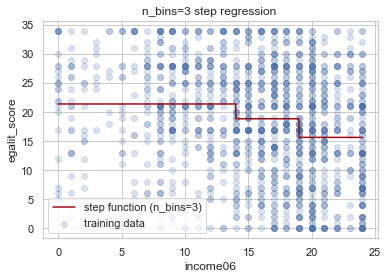

In [127]:
print(bestimator)

inc_plot = np.linspace(inc_tr.min(), inc_tr.max(), 10000).reshape(-1, 1)
y_plot = bestimator.predict(inc_plot)

plt.scatter(inc_tr, y_tr, label='training data', alpha=0.2)
plt.plot(inc_plot, y_plot, label=f'step function (cuts={best_cuts-1})', c=plt.cm.Reds(0.9))
plt.legend()
plot_labels(f'n_bins={best_cuts} step regression ', 'income06', 'egalit_score')

## more BS here

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer as kb
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_discretization.html

step_predictor = Pipeline([('cut', kb()), ('lr', lr())])
parameters = {'cut__n_bins': range(1, 20)}

cv = GridSearchCV(step_predictor, parameters, n_jobs=-1, scoring='neg_mean_squared_error', cv=10)

cv.fit(inc_tr, y_tr)
bestimator = cv.best_estimator_
best_cuts = cv.best_params_['cut__n_bins']-1